# Let's use emcee to see if we can infer the velocity of a star using Adrian's code.

In [9]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import aviary as av

from astropy.coordinates.builtin_frames.galactocentric import get_matrix_vectors

Test the functions for tranforming between position & velocity and proper motion & RV.

In [152]:
sun_xyz = [-8.122, 0, 0] * u.kpc
sun_vxyz = [12.9, 245.6, 7.78] * u.km/u.s

galcen_frame = coord.Galactocentric(galcen_distance=np.abs(sun_xyz[0]),
                                    galcen_v_sun=sun_vxyz,
                                    z_sun=0*u.pc)

# Pre-compute the rotation matrix to go from Galactocentric to ICRS (ra/dec) coordinates
R_gal, _ = get_matrix_vectors(galcen_frame, inverse=True)
print(R_gal)

#Test the function by transforming a coordinate to galactocentric and back:
c = coord.SkyCoord(ra=61.342*u.deg, 
                   dec=17*u.deg, 
                   distance=3*u.kpc,
                   pm_ra_cosdec=4.2*u.mas/u.yr,
                   pm_dec=-7.2*u.mas/u.yr,
                   radial_velocity=17*u.km/u.s)

test_galcen = c.transform_to(galcen_frame)

test_pm, test_rv = av.get_icrs_from_galactocentric(
    test_galcen.data.xyz,
    test_galcen.velocity.d_xyz, R_gal, sun_xyz, sun_vxyz)

assert u.allclose(test_pm[0], c.pm_ra_cosdec)
assert u.allclose(test_pm[1], c.pm_dec)
assert u.allclose(test_rv, c.radial_velocity)

[[-0.05487396  0.49411076 -0.86766549]
 [-0.87343718 -0.44482862 -0.19807824]
 [-0.48383503  0.74698196  0.45598422]]


We want to infer the velocity and distance of a star from its proper motion in ra and dec, and 3-D position, marginalising over RV.

$$p(V_{xyz}, D|\mu_\alpha, \mu_\delta, \alpha, \delta, \pi) = p(\mu_\alpha, \mu_\delta, \alpha, \delta, \pi| V_{xyz}, D)~p(V_{xyz})~p(D)$$

In [153]:
def lnlike_one_star(params, pm, pm_err, pos, pos_err, R_gal, sun_xyz=[-8.122, 0, 0]*u.kpc, sun_vxyz=[12.9, 245.6, 7.78]*u.km/u.s):
    """
    The log-likelihood of the proper motion and position data, given the velocity parameters
    
    Args:
        params (list): A list of vx [km/s], vy [km/s], vz [km/s] and ln(distance [kpc]).
        pm (list): Proper motion in RA and dec in mas/yr. [pmra, pmdec]
        pm_err (list): Uncertainties on proper motion in RA and dec in mas/yr. [pmra_err, pmdec_err]
        pos (list): Positional coordinates, RA [deg], dec [deg] and parallax [mas].
        pos_err (list): Uncertainties on positional coordinates, RA_err [deg], dec_err [deg] and parallax_err [mas].

    Returns:
        The log-likelihood.
        
    """
    
    vx, vy, vz, lnD = params
    D = np.exp(lnD)
    
    # Calculate XYZ position from ra, dec and parallax
    c = coord.SkyCoord(ra = pos[0]*u.deg,
                       dec = pos[1]*u.deg,
                       distance = D*u.kpc)
    
    galcen = c.transform_to(galcen_frame)
    V_xyz_units = [vx, vy, vz]*u.km*u.s**-1
    
    # Calculate pm and rv from XYZ and V_XYZ
    pm_from_v, rv_from_v = av.get_icrs_from_galactocentric(galcen.data.xyz, V_xyz_units, R_gal, sun_xyz, sun_vxyz)
    
    # Compare this proper motion with observed proper motion.
    return -.5*(pm_from_v[0].value - pm[0])**2/pm_err[0]**2 \
           - .5*(pm_from_v[1].value - pm[1])**2/pm_err[1]**2 \
           - .5*(D - 1./pos[2])**2/pos_err[2]**2

Test the lhf.

In [155]:
pm = np.array([4.2, -7.2])
pm_err = np.array([.01, .01])
pos = np.array([61.342, 17., 1./3])
pos_err = np.array([.1, .1, .001])
vx, vy, vz = test_galcen.velocity.d_xyz[0].value, test_galcen.velocity.d_xyz[1].value, test_galcen.velocity.d_xyz[2].value

params = [vx, vy, vz, np.log(3.)]
print(lnlike_one_star(params, pm, pm_err, pos, pos_err, R_gal))

params = [vx, vy, vz, np.log(10.)]
print(lnlike_one_star(params, pm, pm_err, pos, pos_err, R_gal))

params = [vx, vy, vz, np.log(3.)]
print(lnlike_one_star(params, pm+.5, pm_err, pos, pos_err, R_gal))

# %timeit lnlike_one_star([vx, vy, vz, np.log(3.)], pm, pm_err, pos, pos_err, R_gal, sun_xyz, sun_vxyz)

-1.3016204936146695e-25
-24670226.00000001
-2500.0


Priors over velocity and distance.

In [156]:
def lnGauss(x, mu, sigma):
    """
    A log-Gaussian.
    
    """
    ivar = 1./sigma**2
    return -.5*(x - mu)**2 * ivar


def lnprior(params):
    """
    The log-prior over distance and velocity parameters.
    
    Args:
        params (list): A list of vx [km/s], vy [km/s], vz [km/s] and ln(distance [kpc]).

    Returns:
        The log-prior.
        
    """
    
    vx, vy, vz, lnD = params
    
    # A log uniform prior over distance
    if lnD < 5 and -5 < lnD:
        
        # And a Gaussian prior over X, Y and Z velocities
        return lnGauss(vx, 0, 100) \
             + lnGauss(vy, 0, 100) \
             + lnGauss(vz, 0, 100)
    
    else:
        return -np.inf
    

def lnprob(params, pm, pm_err, pos, pos_err, R_gal, sun_xyz=[-8.122, 0, 0]*u.kpc, sun_vxyz=[12.9, 245.6, 7.78]*u.km/u.s):
    """
    The log-probability of the distance and velocity parameters, given proper motion and position. 
    
    Args:
        params (list): A list of vx [km/s], vy [km/s], vz [km/s] and ln(distance [kpc]).
        pm (list): Proper motion in RA and dec in mas/yr. [pmra, pmdec]
        pm_err (list): Uncertainties on proper motion in RA and dec in mas/yr. [pmra_err, pmdec_err]
        pos (list): Positional coordinates, RA [deg], dec [deg] and parallax [mas].
        pos_err (list): Uncertainties on positional coordinates, RA_err [deg], dec_err [deg] and parallax_err [mas].

    Returns:
        The log-probability.
        
    """
    return lnlike_one_star(params, pm, pm_err, pos, pos_err, R_gal, sun_xyz=sun_xyz, sun_vxyz=sun_vxyz) + lnprior(params)

Test prior and prob.

In [157]:
params = vx, vy, vz, np.log(3.)
print(lnprob(params, pm, pm_err, pos, pos_err, R_gal, sun_xyz, sun_vxyz), lnprior(params))

params = vx, vy, vz, np.log(10.)
print(lnprob(params, pm, pm_err, pos, pos_err, R_gal, sun_xyz, sun_vxyz), lnprior(params))

params = vx, vy, vz, np.log(3.)
print(lnprob(params, pm+.5, pm_err, pos, pos_err, R_gal, sun_xyz, sun_vxyz), lnprior(params))

params = vx, vy, vz, 5, 
assert lnprob(params, pm, pm_err, pos, pos_err, R_gal, sun_xyz, sun_vxyz) == -np.inf

params = vx, vy, vz, 4.5
assert lnprob(params, pm, pm_err, pos, pos_err, R_gal, sun_xyz, sun_vxyz) != -np.inf

-0.8751283845427964 -0.8751283845427964
-24670226.875128396 -0.8751283845427964
-2500.8751283845427 -0.8751283845427964


In [158]:
print(vx, vy, vz)

-0.8922743769410216 130.44338147766848 -22.052114773047027


In [163]:
import emcee
import time

ndim, nwalkers = 4, 12
inits = [vx, vy, vz, np.log(3.)]
p0 = np.random.randn(nwalkers, ndim)*1e-4 + inits

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(pm, pm_err, pos, pos_err, R_gal, sun_xyz, sun_vxyz))

start = time.time()
sampler.run_mcmc(p0, 500);
end = time.time()
print(end - start, "s")

31.3565890789032 s


(1176, 4) [-0.8922743769410216, 130.44338147766848, -22.052114773047027, 1.0986122886681098]


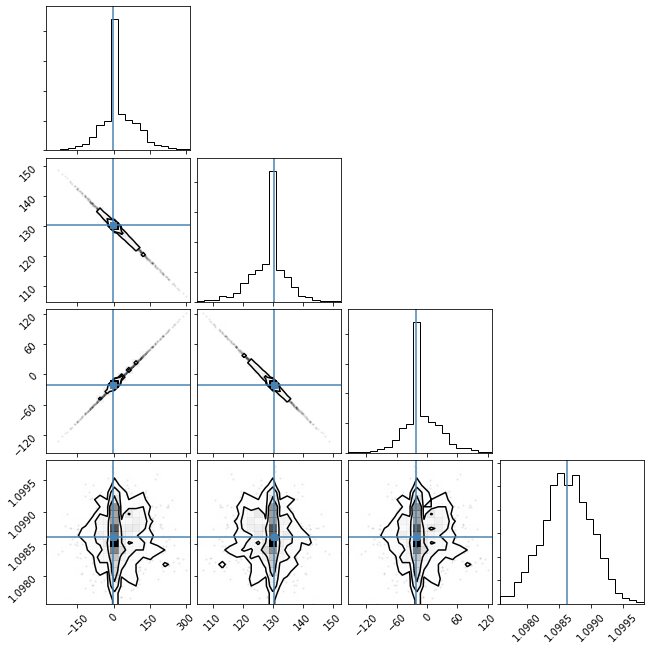

In [164]:
import corner

flat_samples = sampler.get_chain(discard=10, thin=5, flat=True)
print(flat_samples.shape, inits)

fig = corner.corner(flat_samples, truths=inits);